# Drivers of Reddit NBA sentiment
This notebook investigates what drives the sentiment of NBA players on reddit. It roughly has N parts:
1. Building a set of covariates for sentiment (e.g. player demographics, city demographics, performance data)
2. Calculating the sentiment towards each player
3. Performing a regression model to predict player sentiment

This is a work in progress. For similar work on the NFL, see `nfl-sentiment.ipynb`.

For the most fun, I would skip to **Exploration of sentiment values**

### Long term to-do:
Make the covariates and sentiment dataframes use same season (covariates call 2017-2018 "2018", while sentiment calls it "2017")

Create functions for:
  * fuzzy matching cleanup
  * aggregation (maybe)

Get Twitter data for comparison

In [1]:
import json
import string
import pandas as pd
import numpy as np
import seaborn as sns
from ast import literal_eval
from string import punctuation
from sner import Ner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import sports_sentiment as ss
import scrape_player_data as spd

In [3]:
# download stanford core nlp (should be a zip file of format stanford-ner-YYYY-MM-DD) (maybe from https://nlp.stanford.edu/software/CRF-NER.shtml#Download)
# need to start the Java server:
# cd C:\ProgramData\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false

In [4]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [5]:
non_players_set = set('Atlanta Hawks Boston Celtics Brooklyn Nets Charlotte Bobcats ' \
                  'Chicago Bulls Cleveland Cavaliers cavs Dallas Mavericks mavs Denver Nuggets ' \
                  'Detroit Pistons Golden State Warriors Houston Rockets Indiana '\
                  'Pacers Los Angeles LA Clippers LA Lakers LAL Memphis Grizzlies Miami Heat '\
                  'Milwaukee Bucks Minnesota Timberwolves  New Orleans Hornets New York Knicks NYK '\
                  'Oklahoma City Thunder Orlando Magic Philadelphia Sixers 76ers Phoenix '\
                  'Suns Portland Trail Blazers Sacramento Kings '\
                  'San Antonio Spurs Toronto Raptors Utah Jazz Washington Wizards wiz '\
                      'NBA asg KOC woj shams'.lower().split())

In [7]:
#coaches2018_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_current_National_Basketball_Association_head_coaches')[1].iloc[2:, 0].str.strip(string.punctuation).str.lower().str.split(' ').str[-1]
#coaches2018_df.to_csv('d:/data/sentiment_sports/nba_coaches_2018.csv', index=False)
coaches = set(pd.read_csv('d:/data/sentiment_sports/nba_coaches_2018.csv', header = None).iloc[:,0])

In [8]:
non_players_set = non_players_set.union(set(coaches))

### Instantiate sentiment analyzer
For sentiment, I use a modified version of VADER. Many words have different sentiment in the sports world as compared to general usage (e.g. "offensive" is not a negative word in sports).

In [9]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists', 'win']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously', 'loss', 'losses', 'playing', 'vicious',]
bad_words = ['foul', 'ridiculous', 'motherfucking', 'mediocre', 'soft', 'slow', 'delusional']
great_words = ['goat', 'nasty', 'prime', 'mvp']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

## 1. Load player demographic and performance data
### Demographics
#### Ethnicity and height/weight.
It was difficult to find a list of NBA player ethnicities, so I just googled the few hundred players. I downloaded height and weight information from `basketball-reference.com`.

-I also have data from 2013 onwards; need to update it with race info

In [71]:
demo_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_players2013.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()

Fix heights

In [72]:
demo_df['Ht'] = demo_df['Ht'].str.split('-')
height_dict = {'Jun':72, 'Jul':84, 'May':60}
height_dict.update({str(x):x for x in range(13)})
height_dict.update({'00':0})
demo_df['Ht'] = demo_df['Ht'].apply(lambda row: height_dict[row[0]]*12 + height_dict[row[1]])

#### Player performance
Performance data as also downloaded from `basketball-reference.com`.

In [ ]:
'''performance2018_df = spd.get_year_performance_nba(2018).assign(season = lambda row: row['year'] -1)
performance2017_df = spd.get_year_performance_nba(2017).assign(season = lambda row: row['year'] -1)
performance2016_df = spd.get_year_performance_nba(2016).assign(season = lambda row: row['year'] -1)
performance2015_df = spd.get_year_performance_nba(2015).assign(season = lambda row: row['year'] -1)
performance_df = pd.concat([performance2015_df, performance2016_df, performance2017_df, performance2018_df])'''

In [74]:
#performance_df.to_csv('d:/data/sentiment_sports/covariates/nba_stats_2015-2018.tsv', sep='\t', index = False)
performance_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_stats_2015-2018.tsv', sep='\t')

#### Team info
I downloaded team performance data from `basketball-reference.com` as well.

In [75]:
#year=2015
#team2015_df = pd.concat(pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year}.html')[:2]).assign(year = year)
# then hand edit the 3-letter team names
team_df = pd.concat([pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2016.tsv', sep='\t'),
                     pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2017.tsv', sep='\t'),
                     pd.read_csv('d:/data/sentiment_sports/covariates/nba_teams2018.tsv', sep='\t')])

#### Salary

In [82]:
def get_nba_salary_year(season):
    return (pd.read_html(f'https://hoopshype.com/salaries/players/{season}-{season+1}/')[0]
              .rename(columns = {str(season) + '/' +  str(season+1)[2:]: 'salary'})
              .assign(season = season))
salary_df = pd.concat([get_nba_salary_year(season) for season in range(2010, 2019)])[['Player', 'salary', 'season']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


In [83]:
salary_df['Player'] = salary_df['Player'].str.lower()
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
salary_df['salary'] = salary_df['salary'].str[1:].apply(locale.atoi)

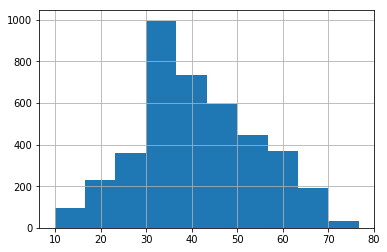

In [84]:
np.power(salary_df['salary'], 1/4).hist();

In [85]:
salary_df['standard_salary'] = np.power(salary_df['salary'], 1/4)

#### City demographics
When thinking about race, we considered whether the demographics of the city influence player popularity. I downloaded census and polling data for NFL cities.

In [68]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])

In [69]:
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

### Combine info
After getting all of the data for various covariates, I combine them into a single dataframe that has performance, demographics, and city information.

In [86]:
covariates_df = (demo_df.merge(performance_df, on = 'Player')
                      .merge(team_df, on=['Tm', 'year'])
                      .merge(city_df, on='Tm')
                      .merge(vote_df, on='Tm') )
covariates_df['Player'] = covariates_df['Player'].str.replace('.', '')
covariates_df = covariates_df.merge(salary_df, on=['Player', 'season'], how='left')
covariates_df['experience'] = covariates_df['year'] - covariates_df['From']
covariates_df.head(2)

,Player,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,Pos_y,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,season,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,alex abrines,W,2017,2018,G-F,78,190,"August 1, 1993",NaN,1,SG,23,68,1055,10.1,0.560,0.724,0.144,1.9,7.1,4.5,5.5,1.7,0.6,8.3,15.9,NaN,1.2,0.9,2.1,0.096,NaN,-0.3,-2.2,-2.5,-0.1,OKC,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,2016,47,1337075,74.1,10.2,0.1051,5994764.0,49.481519,0
1,steven adams,W,2014,2018,C,84,255,"July 20, 1993",University of Pittsburgh,3,C,23,80,2389,16.5,0.589,0.002,0.392,13.0,15.4,14.2,5.4,1.8,2.6,16.0,16.2,NaN,3.3,3.1,6.5,0.130,NaN,-0.7,1.2,0.6,1.5,OKC,4.7,8.2,0.571,0.0,0.0,0.000,4.7,8.2,0.572,0.571,2.0,3.2,0.611,3.5,4.2,7.7,1.1,1.1,1.0,1.8,2.4,11.3,2017,2016,47,1337075,74.1,10.2,0.1051,3140517.0,42.096917,3


#### Player names for entity recognition and fuzzy matching
When extracting named entities, I had to be careful with some names that are common English words (e.g. "Brown"). As a shorter alternative to performing NER, I also sometimes simply extracted player names as keywords.

In [19]:
UNIQUE_NAMES = set(covariates_df.Player.unique())

In [20]:
NAMED_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union({'lma', 'kd', 'lbj', 'klove', 'drose', 'kobe',
                                                            'mj', 'magic', 'bird', 'wilt', 'chamberlain',
                                                            'tt', 'shump', 'kat', 'melo', 'k-love', 'd-wade',
                                                            'boogie', 'bosh', 'iggy'})
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
UPPER_ENTITIES = {'Black', 'Ball', 'Brown', 'Buddy', 'Grant', 'House', 'Smart', 'Holiday', 'Love', 'Rose', 'Smart', 'Stone','Temple', 
                  'Wall', 'Will', 'White', 'Wear', 'Case', 'New', 'Little', 'Shorts', 'City', 'Will', 'Young', 'Blue'}
NAMED_ENTITIES = NAMED_ENTITIES - {'a'} - {name.lower() for name in UPPER_ENTITIES}
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in NAMED_ENTITIES}
NAMED_ENTITIES = NAMED_ENTITIES.union(NOPUNCT_ENTITIES)
NAMED_ENTITIES = NAMED_ENTITIES.union(non_players_set)

## Calculate sentiment 
### Reddit sentiment for 2017-18 season
I created a module, `sentiment_sports` to calculate the sentiment of comments. This function performs a few things:
1. Separates comments into sentences
2. Performs Named entity recognition using either NLTK, or using pre-existing list of entities
3. Calculates sentiment using VADER with a modified lexicon

In [ ]:
%%time
def create_month_df(data_loc):
    return ss.create_sentiment_df(data_loc, sid.polarity_scores, ner_set=NAMED_ENTITIES,
                                  non_players_set=non_players_set, UPPER_NAMES = UPPER_ENTITIES)
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv.gz'
_, oct_df = create_month_df(file_stub.format(201710))
_, nov_df = create_month_df(file_stub.format(201711))
_, dec_df = create_month_df(file_stub.format(201712))
_, jan_df = create_month_df(file_stub.format(201801))
_, feb_df = create_month_df(file_stub.format(201802))
_, mar_df = create_month_df(file_stub.format(201803))
_, apr_df = create_month_df(file_stub.format(201804))
_, may_df = create_month_df(file_stub.format(201805))

In [26]:
nba2017_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2017_df.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


(1209366, 16)

In [27]:
nba2017_df = ss.fuzzy_match_players(nba2017_df, UNIQUE_NAMES)

Fuzzy matching player names


In [28]:
nba2017_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2017.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2016 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
_, oct_df = create_month_df(file_stub.format(201610))
_, nov_df = create_month_df(file_stub.format(201611))
_, dec_df = create_month_df(file_stub.format(201612))
_, jan_df = create_month_df(file_stub.format(201701))
_, feb_df = create_month_df(file_stub.format(201702) + '.gz')
_, mar_df = create_month_df(file_stub.format(201703) + '.gz')
_, apr_df = create_month_df(file_stub.format(201704) + '.gz')
_, may_df = create_month_df(file_stub.format(201705) + '.gz')

In [30]:
nba2016_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2016_df.shape
# previously 888k

(825911, 15)

In [31]:
nba2016_df = ss.fuzzy_match_players(nba2016_df, UNIQUE_NAMES)

Fuzzy matching player names


In [34]:
nba2016_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2016.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2015 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
_, oct_df = create_month_df(file_stub.format(201510))
_, nov_df = create_month_df(file_stub.format(201511))
_, dec_df = create_month_df(file_stub.format(201512))
_, jan_df = create_month_df(file_stub.format(201601))
_, feb_df = create_month_df(file_stub.format(201602))
_, mar_df = create_month_df(file_stub.format(201603))
_, apr_df = create_month_df(file_stub.format(201604))
_, may_df = create_month_df(file_stub.format(201605))

In [33]:
nba2015_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2015_df.shape
#945k using old way

(667124, 15)

In [35]:
nba2015_df = ss.fuzzy_match_players(nba2015_df, UNIQUE_NAMES)

Fuzzy matching player names


In [36]:
nba2015_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2015.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### Save / load

In [87]:
nba2015_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2015.tsv',sep='\t', encoding = 'utf-8')
nba2015_df['named_entities'] = nba2015_df['named_entities'].apply(literal_eval)
nba2016_df = pd.read_csv('d:/data/sentiment_sports//combined_months_ner_sentiment_2016.tsv',sep='\t', encoding = 'utf-8')
nba2016_df['named_entities'] = nba2016_df['named_entities'].apply(literal_eval)
nba2017_df = pd.read_csv('d:/data/sentiment_sports//combined_months_ner_sentiment_2017.tsv',sep='\t', encoding = 'utf-8').drop(columns='Unnamed: 0')
nba2017_df['named_entities'] = nba2017_df['named_entities'].apply(literal_eval)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
nba2015_df['season'] = 2015
nba2016_df['season'] = 2016
nba2017_df['season'] = 2017

#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [89]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'draymond sessions', 'jalen jalen', 'brown markelle', 'kyrie korver', 'kyrie singler',
                    'wade drummond', 'kyrie anderson', 'kyle irving', 'kyle ingles', 'kyle turner', 'kyle turner', 'jabari maker',
                    'walton walton', 'nene kanter', 'courtney love', 'george will', 'charles charles', 'jason aaron', 'lebron jae',
                    'sterling lebron', 'bobby lebron', 'damien', 'cleveland', 'cleveland cleveland', 'ben ben', 'martin', "o'bryant",
                                       'sam sam', 'shaquille shaquille', 'blue', 'jamal curry', 'david westbrook', 'griffin baker', 'chris pau',
                                       'jimmy tyler', 'jamal curry', 'jamal curry' 'london','jackson tatum', 'ball']}
name_map.update({'giannis':'giannis antetokounmpo', 'kd':'kevin durant', 'kd kd': 'kevin durant',
                 'lbj':'lebron james', 'lma':'lamarcus aldridge', 
                 'shump': 'iman shumpert', 'blake': 'blake griffin',
                 'kat': 'karl-anthony towns', 'dwight': 'dwight howard',
                 'boogie':'demarcus cousins', 'demar': 'demar derozan',
                'klove':'kevin love', 'cj': 'c.j. mccollum', 'shabazz': 'shabazz muhammad',
                'ingram': 'brandon ingram', 'manu': 'manu ginobili', 'thon': 'thon maker',
                'simmons': 'ben simmons', 'ben': 'ben simmons',
                'wade': 'dwyane wade', 'wall': 'john wall', 'nance jr': 'larry nance',
                 'mbah moute': 'luc mbah a moute', 'luc': 'luc mbah a moute',
                'lin': 'jeremy lin', 'iggy':'andre igoudala',
                'hayward': 'gordon hayward'})

In [90]:
%%time
nba2017_df['fuzzy_name'] = nba2017_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
nba2016_df['fuzzy_name'] = nba2016_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
nba2015_df['fuzzy_name'] = nba2015_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 52.1 s


Remove players whose names have implicit sentiment

In [91]:
senti_players = ['jerian grant', 'jerami grant', 'marcus smart', 'justin holiday','jrue holiday', 'kevin love', 'derrick favors']
nba2017_df = nba2017_df[nba2017_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
nba2016_df = nba2016_df[nba2016_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
nba2015_df = nba2015_df[nba2015_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

In [92]:
nba_df = pd.concat([nba2015_df, nba2016_df, nba2017_df])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [93]:
match_df = nba_df.query('fuzzy_name != "unclear"')
match_df.shape

(1668166, 17)

## Calculating sentiment towards each player
#### First calculate the average sentiment for each player from each user
A naive approach might simply average the sentiment across all comments; this approach would be biased towards the sentiment of the most common posters. Instead, I calculated the sentiment towards each player by each user, then in a second step averaged the sentiment across users.

In [95]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user', 'season'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'season', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df.head(2)

,fuzzy_name,user,season,compound_mean,compound_std,comment_count
0,aaron brooks,Armandowoof,2015,0.4155,0.0,2
1,aaron gordon,-HeitorVillaLobos-,2017,-0.3182,NaN,1


#### Then calculate the average sentiment to players across all users

In [96]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby(['fuzzy_name', 'season'])
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'season', 'compound_mean_mean', 'compound_mean_std', 'user_count']

## Exploration of sentiment values
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

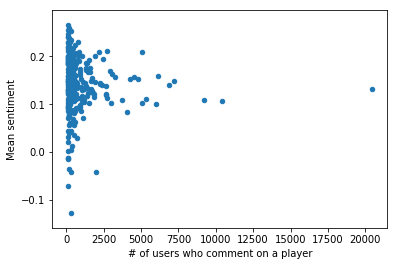

In [69]:
player_sentiment_df.query('user_count> 100 and season ==2017').plot('user_count', 'compound_mean_mean', kind='scatter')
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player')
plt.ylabel('Mean sentiment')

#### Most commented players

In [72]:
player_sentiment_df.query('season ==2017').sort_values('user_count', ascending=False).head()

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
897,lebron james,2017,0.131457,0.344239,20450
828,kevin durant,2017,0.106112,0.379799,10395
594,james harden,2017,0.108789,0.373328,9237
1290,stephen curry,2017,0.148363,0.371226,7183
874,kyrie irving,2017,0.139635,0.378129,6869


#### Players with lowest sentiment
Sterling Brown's sentiment probably reflects a combination of sentiment towards police and himself. Other players on this list like Zaza Pachulia and Salah Mejri are well known disliked players.

In [83]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').head()

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
806,kelly olynyk,2016,-0.044463,0.465392,559
1240,salah mejri,2017,-0.041166,0.468446,298
1494,zaza pachulia,2017,-0.041090,0.429308,1991
1077,nick young,2015,-0.031295,0.465880,241
1493,zaza pachulia,2016,-0.018720,0.435120,1858


In [84]:
player_sentiment_df = player_sentiment_df.query('fuzzy_name != "sterling brown"')

#### Players with highest sentiment
This list seems biased towards players with relatively low comment counts

In [85]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').tail(5)

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
96,bam adebayo,2017,0.252341,0.396970,311
796,karl-anthony towns,2015,0.254626,0.361980,1314
788,justise winslow,2015,0.259658,0.385485,449
924,luke kennard,2017,0.260166,0.385635,215
128,brandon ingram,2015,0.303342,0.329213,244


#### Players with highest std of sentiment
Again, this appears biased towards players with relatively low comment counts.

In [86]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_std').tail(5).iloc[::-1]

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
1060,nate wolters,2016,0.105322,0.471215,300
1240,salah mejri,2017,-0.041166,0.468446,298
1077,nick young,2015,-0.031295,0.465880,241
806,kelly olynyk,2016,-0.044463,0.465392,559
662,jerryd bayless,2015,0.055659,0.461258,224


## Explore demographics relationship with sentiment
#### Join player sentiment to performance and demographics
To see how sentiment is related to demographics, we can join the sentiment table above with the player demographics dataframe `covariates_df`.

I include only players with at least 50 comments to remove noise

In [97]:
join_df = (player_sentiment_df.query('user_count > 50')
                         .merge(covariates_df, left_on = ['fuzzy_name', 'season'], right_on = ['Player', 'season'])
                          .drop(columns=['Unnamed: 19', 'Unnamed: 24']))

#### Sentiment versus performance
Surprisingly, there seems to be relatively little correlation between player performance and sentiment towards the player

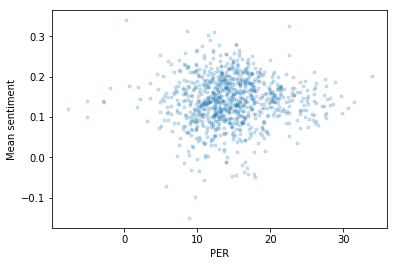

In [88]:
plt.plot(join_df['PER'].values, join_df['compound_mean_mean'].values, '.',alpha= 0.2);
plt.xlabel('PER')
plt.ylabel('Mean sentiment');

#### Sentiment and race
On average, sentiment towards black players is slightly lower than towards white players

In [89]:
join_df.groupby('Race').mean()

,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
Race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,2016.250000,0.140994,0.413642,742.250000,2012.750000,2018.000000,8.750000,202.500000,312.500000,26.500000,33.250000,770.000000,12.700000,0.498000,0.365250,0.428000,2.250000,10.125000,6.225000,20.825000,1.125000,3.125000,17.100000,24.225000,0.525000,0.825000,1.325000,0.045250,-2.950000,-1.975000,-4.900000,0.275000,3.500000,8.550000,0.363750,0.925000,2.575000,0.328250,2.600000,5.975000,0.408500,0.412750,3.425000,3.825000,0.824500,0.275000,1.750000,2.050000,3.050000,0.500000,0.425000,1.975000,2.025000,11.350000,2017.250000,40.250000,1.223166e+07,62.875000,18.400000,0.414825,4.500000
B,2016.161585,0.141375,0.415552,595.007622,2011.745427,2018.000000,12.158537,217.178354,250.640244,26.396341,62.080793,1572.551829,14.480488,0.539432,0.311252,0.261356,4.520732,15.142378,9.844817,14.810976,1.658232,1.689024,12.698626,19.833841,1.878201,1.626220,3.503201,0.092497,-0.459756,-0.109146,-0.568445,0.991159,3.991159,8.774543,0.452518,0.965549,2.714024,0.319750,3.026372,6.061738,0.493181,0.506447,1.839329,2.396037,0.750290,0.940396,3.269817,4.205183,2.413872,0.811890,0.481707,1.409604,1.914634,10.782165,2017.161585,42.111280,5.303007e+06,67.165854,15.062805,0.375905,5.416159
M,2016.117647,0.137208,0.411154,1416.441176,2012.058824,2017.882353,11.735294,208.823529,288.588235,26.029412,61.941176,1672.411765,16.473529,0.542529,0.270412,0.251147,4.650000,14.294118,9.541176,19.647059,1.797059,1.152941,12.985294,21.970588,2.547059,1.697059,4.217647,0.109529,0.882353,-0.164706,0.708824,1.388235,4.955882,10.644118,0.462294,1.294118,3.382353,0.312061,3.658824,7.252941,0.496735,0.512412,2.000000,2.638235,0.734765,1.000000,3.355882,4.364706,3.235294,0.908824,0.350000,1.632353,1.920588,13.191176,2017.117647,44.176471,8.189425e+06,61.585294,8.776471,0.427318,5.058824
R,2016.250000,0.032163,0.454184,159.000000,2016.500000,2018.000000,9.000000,241.250000,323.500000,28.500000,54.000000,638.250000,13.625000,0.592250,0.123250,0.444750,9.650000,22.100000,15.725000,5.150000,1.425000,5.875000,18.650000,13.625000,0.575000,1.125000,1.725000,0.119000,-3.575000,3.275000,-0.300000,0.300000,1.250000,2.375000,0.562000,0.125000,0.350000,0.171750,1.150000,2.025000,0.565750,0.582250,0.600000,1.025000,0.585750,1.050000,2.275000,3.325000,0.400000,0.325000,0.800000,0.625000,1.650000,3.275000,2017.250000,38.500000,6.400053e+06,71.600000,13.475000,0.292175,0.750000
W,2016.196970,0.139395,0.414877,397.090909,2012.454545,2018.000000,11.833333,232.292929,248.282828,26.717172,61.803030,1402.146465,14.411616,0.558242,0.303268,0.299894,6.027778,17.806566,11.907071,11.371212,1.298485,1.877778,13.285859,18.320202,1.808586,1.511111,3.322222,0.104717,-0.680808,-0.051010,-0.731818,0.748990,3.320707,7.103535,0.469056,0.828788,2.230303,0.322540,2.491414,4.876768,0.506010,0.524702,1.474747,1.912626,0.753789,1.086869,3.368182,4.452525,1.705051,0.570202,0.480303,1.150505,1.892929,8.942424,2017.196970,41.348485,5.573069e+06,68.615152,14.261111,0.375646,4.742424


#### Sentiment and age / experience
Generally, sentiment seems to be higher for young and old players (where there is selection bias in that skilled / popular players have longer careers).

Text(0,0.5,'Mean sentiment')

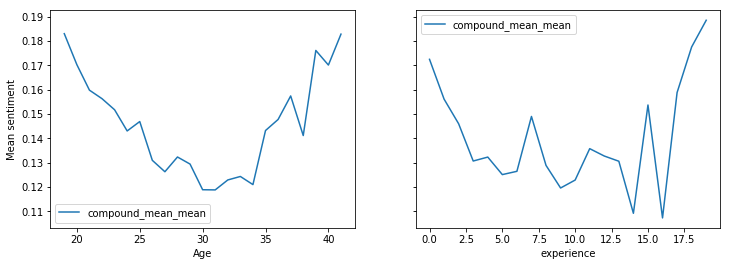

In [90]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax1);
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax2);
ax1.set_ylabel('Mean sentiment')

#### Height

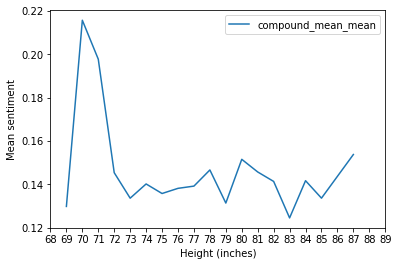

In [106]:
join_df.groupby('Ht').mean().reset_index().plot('Ht', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

### Team and position

In [107]:
join_df.groupby('Pos_y').mean().reset_index()

,Pos_y,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
0,C,2016.200000,0.137689,0.415894,532.512821,2011.692308,2018.000000,83.194872,252.261538,257.451282,26.702564,61.548718,1381.820513,17.424103,0.575164,0.085969,0.391364,10.020000,23.110769,16.565641,9.700000,1.417949,3.592821,14.390769,18.769231,2.276410,1.954359,4.228718,0.136426,-0.976410,1.574359,0.597949,1.184615,3.688718,6.992821,0.533077,0.243590,0.708718,0.212289,3.442564,6.285641,0.550395,0.546810,1.705128,2.489231,0.681596,1.886154,4.521026,6.406154,1.360513,0.577436,0.917949,1.267179,2.211795,9.322564,2017.200000,42.266667,5.927301e+06,66.501538,15.060513,0.398361,5.507692
1,PF,2016.147239,0.141680,0.414822,634.202454,2011.944785,2018.000000,81.398773,235.595092,248.067485,26.226994,63.963190,1525.736196,14.516564,0.546755,0.317491,0.246313,6.309202,18.563190,12.438037,9.942945,1.319632,2.043558,11.724540,18.990798,1.771779,1.701840,3.477914,0.100025,-0.720859,0.080368,-0.638650,0.860736,3.768098,8.098773,0.461466,0.874847,2.459509,0.333892,2.893252,5.650307,0.507975,0.517564,1.558896,2.065644,0.733906,1.205521,3.856442,5.053374,1.569325,0.623926,0.574233,1.160736,1.962577,9.969939,2017.147239,42.521472,5.119228e+06,68.382822,13.795092,0.380289,5.202454
2,PF-C,2015.500000,0.162108,0.425615,172.000000,2010.500000,2018.000000,83.000000,237.500000,199.500000,28.500000,70.000000,1090.000000,12.750000,0.547500,0.484500,0.159000,5.600000,19.400000,12.500000,9.750000,1.250000,1.200000,11.900000,16.800000,1.000000,1.200000,2.250000,0.097000,-0.900000,-0.450000,-1.350000,0.200000,2.150000,4.900000,0.439000,0.900000,2.400000,0.362000,1.250000,2.500000,0.514000,0.529500,0.550000,0.750000,0.743500,0.750000,2.700000,3.450000,1.000000,0.400000,0.250000,0.700000,1.500000,5.750000,2016.500000,41.000000,1.832792e+06,72.650000,13.250000,0.175750,6.000000
3,PG,2016.205405,0.138670,0.417091,705.027027,2012.237838,2017.978378,74.400000,189.086486,276.713514,26.145946,58.994595,1543.870270,14.916757,0.525427,0.319141,0.258941,2.283243,11.176216,6.730811,26.610811,1.849730,0.796757,14.908108,21.894054,2.090270,1.441081,3.529730,0.086216,0.285946,-0.935676,-0.651892,1.165946,4.171351,9.598378,0.427865,1.127027,3.132973,0.340579,3.045946,6.459459,0.463228,0.484454,2.118378,2.606486,0.786311,0.516216,2.500000,3.018919,4.376216,0.934595,0.236216,1.837297,1.802703,11.579459,2017.205405,41.578378,5.520117e+06,67.611892,14.506486,0.367506,4.967568
4,PG-SG,2017.000000,0.093200,0.435828,54.000000,2014.000000,2018.000000,72.000000,201.000000,84.000000,26.000000,20.000000,422.000000,13.500000,0.539000,0.482000,0.372000,1.500000,10.000000,5.700000,26.700000,1.800000,0.200000,15.400000,18.900000,0.500000,0.100000,0.600000,0.072000,0.100000,-2.500000,-2.400000,0.000000,2.600000,6.900000,0.380000,1.100000,3.300000,0.333000,1.500000,3.600000,0.423000,0.460000,2.300000,2.600000,0.902000,0.300000,2.000000,2.300000,3.800000,0.800000,0.100000,1.500000,1.800000,8.600000,2018.000000,21.000000,4.486153e+06,78.700000,5.200000,0.034500,4.000000
5,SF,2016.113208,0.141222,0.413906,551.383648,2011.911950,2018.000000,79.654088,220.238994,240.408805,26.377358,62.327044,1649.081761,12.584277,0.527358,0.391157,0.233050,3.402516,14.001887,8.712579,10.764151,1.722642,1.249686,11.446541,18.306289,1.702516,1.639623,3.338994,0.077824,-0.791195,-0.103145,-0.894969,0.955975,3.769182,8.512579,0.429434,1.109434,3.144025,0.336627,2.661006,5.366667,0.487595,0.494799,1.724528,2.200000,0.755438,0.746541,3.146541,3.887421,1.841509,0.869182,0.368553,1.208805,1.837107,10.369182,2017.113208,41.761006,5.415223e+06,67.666667,14.475472,0.372979,5.201258
6,SF-SG,2017.000000,0.122746,0.415415,508.000000,2011.000000,2018.000000,79.500

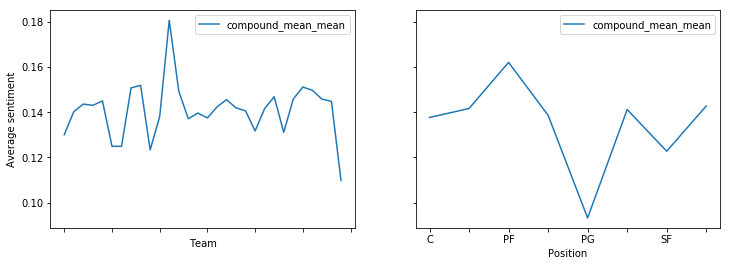

In [108]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Tm').mean().reset_index().plot('Tm', 'compound_mean_mean', ax = ax1);
ax1.set_xlabel('Team')
ax1.set_ylabel('Average sentiment')
join_df.groupby('Pos_y').mean().reset_index().plot('Pos_y', 'compound_mean_mean', ax = ax2);
ax2.set_xlabel('Position')
ax2.set_xticklabels(['', 'C','', 'PF','', 'PG','', 'SF','', 'SG']);

In [109]:
join_df.groupby('Tm').mean().sort_values('compound_mean_mean').head(2)

,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
Tm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WAS,2016.125000,0.109831,0.415349,372.093750,2011.406250,2018.0,79.156250,215.312500,298.593750,26.968750,66.843750,1669.156250,14.400000,0.555581,0.270613,0.276258,4.500000,17.868750,11.359375,14.850000,1.621875,1.509375,13.354839,18.762500,2.118750,1.715625,3.821875,0.100625,-0.865625,-0.209375,-1.071875,1.053125,3.937500,8.371875,0.472355,0.865625,2.346875,0.313310,3.068750,6.040625,0.508935,0.521613,1.706250,2.256250,0.750806,0.937500,3.187500,4.125000,2.540625,0.834375,0.418750,1.400000,2.046875,10.443750,2017.125000,44.312500,6011752.0,55.1,25.4,0.3622,5.718750
GSW,2016.102564,0.123340,0.409708,1807.846154,2010.410256,2018.0,79.538462,220.358974,248.692308,27.564103,65.846154,1420.461538,16.702564,0.587308,0.257179,0.251462,5.969231,15.505128,11.041026,15.407692,1.666667,2.438462,13.966667,18.894872,2.779487,1.933333,4.702564,0.149923,0.648718,0.500000,1.151282,1.607692,3.715385,7.451282,0.512231,1.033333,2.625641,0.323615,2.664103,4.825641,0.555205,0.560590,1.471795,1.853846,0.748789,0.807692,3.048718,3.841026,2.579487,0.741026,0.579487,1.269231,1.684615,9.946154,2017.102564,65.230769,4577530.0,52.1,7.6,0.6444,6.692308


#### Create modeling dataframe

In [98]:
join_df['youth'] = (join_df['Age'].mean() - join_df['Age']).clip(0)
join_df['oldness'] = (join_df['Age'] - join_df['Age'].mean()).clip(0)

In [99]:
join_df = join_df.query('Race != "A" and Race != "R"')

In [100]:
join_df['ThreePP'] =join_df['ThreePP'].fillna(join_df['ThreePP'].mean())
join_df['white_black_diff'] = join_df['metro_percent_white'] - join_df['metro_percent_black']

In [101]:
join_df['height_dummies'] = pd.cut(join_df['Ht'], [0, 72, 79, 100], labels = ['short', 'medium', 'tall'])

In [111]:
join_df.to_csv('modeling_data/nba_model_data.tsv', sep='\t', index=False)

In [103]:
fit_df = join_df.replace({'M':'B', 'L':'W'})#.query('user_count > 200')#

In [104]:
fit_df.head(2)

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count,Player,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,Pos_y,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience,youth,oldness,white_black_diff,height_dummies
0,aaron gordon,2015,0.196881,0.382909,98,aaron gordon,B,2015,2018,F,81,220,"September 16, 1995",University of Arizona,159,PF,20,78,1863,17.0,0.541,0.245,0.333,9.0,21.3,15.1,10.3,1.6,2.4,9.0,17.3,3.2,2.2,5.4,0.139,0.6,1.2,1.8,1.8,ORL,3.5,7.4,0.473,0.5,1.8,0.296,3.0,5.6,0.531,0.509,1.7,2.5,0.668,2.0,4.5,6.5,1.6,0.8,0.7,0.8,2.0,9.2,2016,35,2328508,71.2,16.3,0.2464,4171680.0,45.193684,1,6.41049,0.0,54.9,tall
1,aaron gordon,2016,0.133385,0.428750,113,aaron gordon,B,2015,2018,F,81,220,"September 16, 1995",University of Arizona,157,SF,21,80,2298,14.5,0.530,0.309,0.251,5.3,14.1,9.6,10.5,1.4,1.4,8.5,20.1,2.0,1.7,3.7,0.077,-0.2,-0.4,-0.7,0.8,ORL,4.9,10.8,0.454,1.0,3.3,0.288,4.0,7.5,0.528,0.499,2.0,2.7,0.719,1.5,3.6,5.1,1.9,0.8,0.5,1.1,2.2,12.7,2017,29,2328508,71.2,16.3,0.2464,4351320.0,45.672550,2,5.41049,0.0,54.9,tall


## Regression models
### Working models
First, a regression model for sentiment with features for performance, age, team wins, race, and height.

In [109]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + Wins + C(height_dummies) + ' \
                       'G + PPG * standard_salary + ThreePP + DWS + TRB + AST + BLK + STL + TOV + total_population+ C(Race) * white_black_diff + C(Race) * clinton_vote_lead',
                data = fit_df,
               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [110]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.146
Model:                            WLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     6.376
Date:                Sun, 14 Oct 2018   Prob (F-statistic):           1.68e-17
Time:                        11:49:19   Log-Likelihood:                 1246.0
No. Observations:                 841   AIC:                            -2446.
Df Residuals:                     818   BIC:                            -2337.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.1769      0.023      7.812      0.000       0.132       0.221
C(height_dummies)[T.medium]       -0.0032      0.010     -0.302      0.763      -0.024       0.017
C(height_dummies)[T.tall]         -0.0021      0.011     -0.184      0.854      -0.024       0.020
C(Race)[T.W]                       0.0068      0.021      0.319      0.750      -0.035       0.049
youth                              0.0075      0.001      7.015      0.000       0.005       0.010
oldness                            0.0023      0.001      3.198      0.001       0.001       0.004
Wins                              -0.0007      0.000     -3.479      0.001      -0.001      -0.000
G                                 -0.0004      0.000     -3.025      0.003      -0.001      -0.000
PPG                                0.0014      0.001      1.093      0.275      -0.001       0.004
standard_salary                   -0.0005      0.000     -1.666      0.096      -0.001    8.49e-05
PPG:standard_salary             1.405e-05   1.97e-05      0.713      0.476   -2.47e-05    5.28e-05
ThreePP                            0.0226      0.015      1.461      0.144      -0.008       0.053
DWS                                0.0114      0.004      3.217      0.001       0.004       0.018
TRB                               -0.0038      0.001     -2.752      0.006      -0.006      -0.001
AST                             3.437e-05      0.002      0.019      0.985      -0.003       0.004
BLK                                0.0020      0.005      0.377      0.706      -0.008       0.013
STL                                0.0045      0.006      0.730      0.466      -0.008       0.017
TOV                               -0.0140      0.005     -2.789      0.005      -0.024      -0.004
total_population               -2.611e-10   4.63e-10     -0.563      0.573   -1.17e-09    6.49e-10
white_black_diff                3.977e-05      0.000      0.287      0.774      -0.000       0.000
C(Race)[T.W]:white_black_diff      0.0002      0.000      0.792      0.428      -0.000       0.001
clinton_vote_lead                  0.0100      0.012      0.811      0.417      -0.014       0.034
C(Race)[T.W]:clinton_vote_lead    -0.0449      0.023     -1.916      0.056      -0.091       0.001
==============================================================================
Omnibus:                       71.573   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.863
Skew:                          -0.581   Prob(JB):                     1.27e-27
Kurtosis:                       4.478   Cond. No.                     1.23e+08
==============================================================================

Warnings:
[1] Standard Errors assu

In [307]:
predicted_senti = model.predict(fit_df[['PER', 'youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall']])

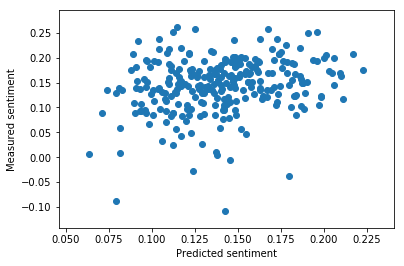

In [308]:
plt.scatter(predicted_senti, fit_df['compound_mean_mean'])
plt.xlabel('Predicted sentiment')
plt.ylabel('Measured sentiment');

### Simple models for abstract
First, a regression model with team wins, age, oldness, PER, and ethnicity

In [180]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.ols( formula = 'compound_mean_mean ~ youth + oldness + Wins + PER + C(Race)',
                data = fit_df,
#               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [181]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     3.353
Date:                Fri, 28 Sep 2018   Prob (F-statistic):            0.00349
Time:                        15:02:03   Log-Likelihood:                 376.11
No. Observations:                 232   AIC:                            -738.2
Df Residuals:                     225   BIC:                            -714.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1006      0.016      6.208      0.000       0.069       0.133
C(Race)[T.M]     0.0169      0.015      1.112      0.267      -0.013       0.047
C(Race)[T.W]     0.0153      0.008      1.968      0.050   -2.16e-05       0.031
youth            0.0073      0.002      3.962      0.000       0.004       0.011
oldness          0.0028      0.001      2.371      0.019       0.000       0.005
Wins             0.0003      0.000      0.955      0.340      -0.000       0.001
PER              0.0005      0.001      0.889      0.375      -0.001       0.002
==============================================================================
Omnibus:                       74.225   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.726
Skew:                          -1.310   Prob(JB):                     8.02e-56
Kurtosis:                       7.403   Cond. No.                         242.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### With interaction

In [176]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + Wins + PER + C(Race) * white_black_diff',
                data = fit_df,
#               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [126]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.070
Model:                            WLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.363
Date:                Fri, 28 Sep 2018   Prob (F-statistic):            0.00179
Time:                        14:38:20   Log-Likelihood:                 492.99
No. Observations:                 323   AIC:                            -970.0
Df Residuals:                     315   BIC:                            -939.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1118      0.017      6.412      0.000       0.077       0.146
C(Race)[T.W]                     -0.0266      0.023     -1.133      0.258      -0.073       0.020
youth                             0.0073      0.002      4.129      0.000       0.004       0.011
oldness                           0.0020      0.001      1.765      0.079      -0.000       0.004
Wins                              0.0001      0.000      0.537      0.592      -0.000       0.001
PER                               0.0010      0.001      1.841      0.067   -6.95e-05       0.002
white_black_diff                 -0.0001      0.000     -0.645      0.519      -0.001       0.000
C(Race)[T.W]:white_black_diff     0.0007      0.000      1.593      0.112      -0.000       0.001
==============================================================================
Omnibus:                       58.807   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.801
Skew:                          -0.907   Prob(JB):                     1.45e-29
Kurtosis:                       5.565   Cond. No.                         607.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

simple_model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + Wins + PER + C(Race) * clinton_vote_lead',
                data = fit_df,
#               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [128]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.077
Model:                            WLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.769
Date:                Fri, 28 Sep 2018   Prob (F-statistic):           0.000610
Time:                        14:38:50   Log-Likelihood:                 494.34
No. Observations:                 323   AIC:                            -972.7
Df Residuals:                     315   BIC:                            -942.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0904      0.015      5.852      0.000       0.060       0.121
C(Race)[T.W]                       0.0329      0.016      2.115      0.035       0.002       0.063
youth                              0.0074      0.002      4.234      0.000       0.004       0.011
oldness                            0.0020      0.001      1.768      0.078      -0.000       0.004
Wins                               0.0001      0.000      0.573      0.567      -0.000       0.001
PER                                0.0010      0.001      1.745      0.082      -0.000       0.002
clinton_vote_lead                  0.0381      0.018      2.150      0.032       0.003       0.073
C(Race)[T.W]:clinton_vote_lead    -0.0622      0.036     -1.739      0.083      -0.133       0.008
==============================================================================
Omnibus:                       57.177   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.306
Skew:                          -0.894   Prob(JB):                     6.17e-28
Kurtosis:                       5.473   Cond. No.                         617.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Figures for Sloan abstract

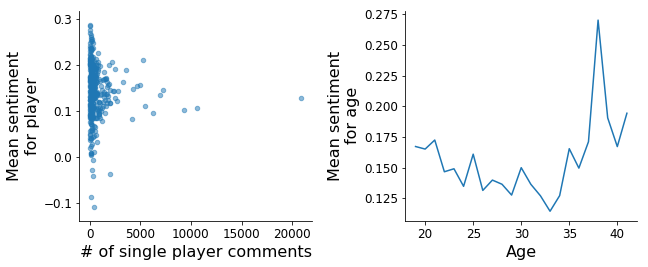

In [238]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = [10, 4])
fs = 16
player_sentiment_df.query('user_count> 50').plot('user_count', 'compound_mean_mean', kind='scatter', alpha = 0.5, ax = ax1)
#plt.plot([100, 100], [-0.1, 0.3])
plt.subplots_adjust(wspace=0.4)
ax1.tick_params(labelsize = fs-4)
ax1.set_xlabel('# of single player comments', fontsize = fs)
ax1.set_ylabel('Mean sentiment\nfor player', fontsize = fs)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
join_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax2);
ax2.tick_params(labelsize = fs-4)
ax2.set_xlabel('Age', fontsize = fs)
ax2.set_ylabel('Mean sentiment\nfor age', fontsize = fs)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend_.remove()
plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('comment count and age.png')